## Notebook 4: Model Training and Evaluation

In this notebook, we build and evaluate our machine learning model. We will use a Random Forest classifier, a robust algorithm that handles non-linear relationships well (z.B., "Rank matters, but maybe less so on Clay").

Strategy:
- Input: atp_matches_final.csv (containing Elo, rolling stats, H2H, etc.).
- Model: Random Forest classifier (robust to non-linear data).
- Objective: Beat the "rankings baseline" (accuracy > 65%).

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Display settings
pd.set_option('display.max_columns', None)

# Load the final dataset
df = pd.read_csv('master_data_final.csv')
df['tourney_date'] = pd.to_datetime(df['tourney_date'])

# 2. Filter for "Modern Era" (2000+)
# We drop matches before 2000 to reduce noise from the serve-and-volley era.
df = df[df['tourney_date'].dt.year >= 2000].reset_index(drop=True)
print(f"Data Loaded: {len(df):,} matches (2000-Present)")

Data Loaded: 156,176 matches (2000-Present)


## 2. Data Splitting (Train/Val/Test)

Now, we divide our ~156k matches (double-counted from 2000 to present) into three specific buckets to train and test the model fairly. We implement a custom "temporal split" to simulate forecasting.

1. Training Set (2000–2024):
    - The model studies these 25 years of matches to learn the fundamental laws of tennis
    - Why 2000+? This covers the modern era (Federer/Nadal/Djokovic) while removing pre-2000 noise (z.B., serve-and-volley playstyle). 
    - Wawrinka (oldest active threat in AO 2026) turned pro in 2002, so this captures his entire career.
1. Validation Set (2025–2026 Non-Test):
    - All matches in 2025 and 2026 except the two hard-court Grand Slams. 
    - This includes Roland Garros 2025, Wimbledon 2025, and Masters/ATP 500/ATP 250 events. 
    - It helps us tune the model on "recent" data without seeing the specific test exams.
1. Test Set (AO 2025 & USO 2025):
    - Why these two? They are the most recent hard-court Grand Slams (best-of-five sets). They have the exact format of our target (AO 2026).
    - If our model fails here, it is likely to fail for AO 2026.





In [68]:
# 1. Define Test Set criteria (d.h. hard-court Grand Slams)
# We specifically isolate AO 2025 and USO 2025.
# These mirror the conditions of our future target (AO 2026).
test_mask = (
    (df['tourney_date'].dt.year == 2025) & 
    (df['tourney_name'].isin(['Australian Open', 'US Open']))
)

# 2. Define Validation Set criteria (the rest of 2025-2026)
# Isolate any match in 2025 or 2026 that is NOT in the Test Set.
# This includes RG 2025, Wimbledon 2025, Indian Wells 2026, etc.
val_mask = (
    (df['tourney_date'].dt.year >= 2025) & 
    (~test_mask)  # tilde is a logical NOT
)

# 3. Define Training Set criteria (2000-2024)
# This is strictly everything before 2025.
train_mask = (df['tourney_date'].dt.year < 2025)

# 4. Create test set dataframes
train_df = df[train_mask].copy()
val_df = df[val_mask].copy()
test_df = df[test_mask].copy()

# 5. Verify the splits
print("Data split summary:")
print(f"Training Set (2000-2024):  {len(train_df):,} rows")
print(f"Validation Set (2025-2026):  {len(val_df):,} rows")
print(f"Test Set (AO 2025/USO 2025):   {len(test_df):,} rows")
print(f"Total rows checked:        {len(train_df) + len(val_df) + len(test_df):,} rows (should match {len(df):,})")

# 6. Verify the Test Set
# Make sure we caught the right tournaments (d.h. AO 2025, USO 2025)
print("\nVerify Test Set tournaments:")
unique_tests = test_df['tourney_name'].unique()
print(list(unique_tests))

if ((len(unique_tests) == 2) and ('Australian Open' in unique_tests) and ('US Open' in unique_tests)):
    print("SUCCESS: Test Set correctly isolated the two hard court Slams.")
else:
    print("WARNING: Test Set might contain unexpected tournaments!")

Data split summary:
Training Set (2000-2024):  150,182 rows
Validation Set (2025-2026):  5,486 rows
Test Set (AO 2025/USO 2025):   508 rows
Total rows checked:        156,176 rows (should match 156,176)

Verify Test Set tournaments:
['Australian Open', 'US Open']
SUCCESS: Test Set correctly isolated the two hard court Slams.


## 3. Feature Selection and Preprocessing

We prepare the raw data for the machine learning model.
1. Feature selection: We select the specific columns that the model is "allowed" to see.
    - Standard stats: Rankings, Elo, age, height, H2H.
    - "Context": Surface, tournament level, draw size.
    - "Form": P1's rolling stats (serve %, break point save %) and recent win rates. 

1. Encoding categorical data: Machine Learning models require numbers, not words. We convert text categories into numerical codes:
    - Surface: 
        - Hard = 0
        - Clay = 1
        - Grass = 2 
        - Carpet = 3
    - Level: We map them by "Prestige" so the model understands that a Grand Slam (G) is "higher" than a Challenger (C).
        - 'G' (Grand Slam) $\rightarrow$ 0
        - 'F' (Tour Finals) $\rightarrow$ 1
        - 'M' (Masters 1000) $\rightarrow$ 2
        - $\cdots$
        - 'S' (Futures) $\rightarrow$ 6

In [69]:
# 1. Feature List (The Inputs)
# These are the columns the model will use to predict the 'target'.
features = [
    # Context
    'surface_code', 'draw_size', 'tourney_level_code',
    
    # Player stats (P1 vs P2)
    'p1_rank', 'p2_rank',
    'p1_elo', 'p2_elo',
    'p1_surface_elo', 'p2_surface_elo',
    
    # Physical attributes
    'p1_age', 'p2_age', 'p1_ht', 'p2_ht',
    
    # History
    'p1_h2h_wins', 'p1_h2h_losses',
    
    # Form (P1's recent performance)
    # We don't need P2's rolling stats here because the model sees every match twice.
    # When it sees the "Target=0" row (P2 wins), P2 becomes "P1", then we see their stats.
    'rolling_p1_ace_pct', 'rolling_p1_df_pct',
    'rolling_p1_1st_in_pct', 'rolling_p1_1st_win_pct',
    'rolling_p1_2nd_win_pct', 'rolling_p1_sv_win_pct',
    'rolling_p1_bp_save_pct', 'rolling_p1_bp_convert_pct',
    'p1_surface_win_pct', 'p1_form_win_pct'
]

# 2. Encoding maps (Text -> Numbers)
surface_map = {'Hard': 0, 'Clay': 1, 'Grass': 2, 'Carpet': 3, 'Unknown': 0}

# Ordinal encoding for level (0 = highest prestige)
level_map = {
    'G': 0,  # Grand Slam
    'F': 1,  # Tour Finals
    'M': 2,  # Masters 1000
    'A': 3,  # ATP 500 / 250
    'D': 4,  # Davis Cup
    'C': 5,  # Challengers
    'S': 6   # Futures
}

# 3. Preprocessing function
def preprocess(data):
    d = data.copy()
    
    # Apply mappings
    d['surface_code'] = d['surface'].map(surface_map).fillna(0) # Default to Hard if unknown
    d['tourney_level_code'] = d['tourney_level'].map(level_map).fillna(5) # Default to Challenger
    
    # Handling missing values (just in case)
    # We drop rows where critical features are NaN. 
    # In our clean pipeline, this should be zero rows, but it's a safety net.
    d = d.dropna(subset=features)
    
    return d

# 4. Apply to splits
print("Preprocessing Training Set...")
train_ready = preprocess(train_df)

print("Preprocessing Validation Set...")
val_ready = preprocess(val_df)

print("Preprocessing Test Set...")
test_ready = preprocess(test_df)

# 5. Separate features (X) and target (y)
X_train = train_ready[features]
y_train = train_ready['target']

X_val = val_ready[features]
y_val = val_ready['target']

X_test = test_ready[features]
y_test = test_ready['target']

print(f"\nFeatures Ready. \nInput Shape: {X_train.shape}")
print(f"Target Variable: {y_train.name}")
print(f"Example Feature Vector (First Row):\n{X_train.iloc[0]}")

Preprocessing Training Set...
Preprocessing Validation Set...
Preprocessing Test Set...

Features Ready. 
Input Shape: (150182, 25)
Target Variable: target
Example Feature Vector (First Row):
surface_code                    0.000000
draw_size                       4.000000
tourney_level_code              4.000000
p1_rank                      1314.000000
p2_rank                      1382.000000
p1_elo                       1500.000000
p2_elo                       1500.000000
p1_surface_elo               1500.000000
p2_surface_elo               1500.000000
p1_age                         25.344000
p2_age                         24.602000
p1_ht                         185.000000
p2_ht                         185.000000
p1_h2h_wins                     0.000000
p1_h2h_losses                   0.000000
rolling_p1_ace_pct              0.037727
rolling_p1_df_pct               0.019846
rolling_p1_1st_in_pct           0.310334
rolling_p1_1st_win_pct          0.367535
rolling_p1_2nd_win_pct       

## 4. Model Training (Random Forest)

We are now ready to train the Random Forest Classifier.

### Why Random Forest?
1. Non-Linearity: Tennis is not linear. Being ranked #1 vs #50 matters more than #100 vs #150. Random Forest handles these "steps" and thresholds naturally.
2. Interactions: It can learn complex rules like "If Surface is Clay AND Player 1 has High Clay Elo, then Rank matters less."
3. Hyperparameters:
    - n_estimators = 100: We build 100 independent decision trees and let them vote.
    - min_samples_leaf = 50: Crucial for preventing *overfitting*. We force every "leaf" (final decision node) to contain at least 50 matches. This stops the model from memorizing specific matches (z.B., "That one time Federer lost to Donskoy in Dubai"). It forces the model to learn general patterns instead.
    - max_depth = 15: This limits how deep the trees can grow, preventing overfitting and keeping the model generalizable.

In [70]:
print("Initializing Random Forest classifier...")

# 1. Initialize the Model
rf_model = RandomForestClassifier(
    n_estimators = 100,     # Number of trees in the forest
    min_samples_leaf = 50,  # Regularization: Each leaf must represent 50+ matches
    max_depth = 15,         # Regularization: Limit tree complexity
    random_state = 42,      # Ensures we get the exact same results every time
    n_jobs = -1,            # Use all available CPU cores for speed
    verbose = 1             # Show progress bar
)

# 2. Train the model (Fit)
# The model looks at X_train (features) and learns to predict y_train (target).
print(f"Training on {len(X_train):,} matches...")
rf_model.fit(X_train, y_train)

print("Training Complete.")

Initializing Random Forest classifier...
Training on 150,182 matches...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.8s


Training Complete.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.0s finished


## 5. Model Evaluation

We evaluate the model on two specific datasets:
- Validation Set: General tour performance (Masters, ATP 500s in 2025/26).
- Test Set: The Exam (Australian Open 2025 & US Open 2025).

Then, we compare our model against a "Rankings Baseline."
- Baseline Logic: Always predict the player with the better (lower) rank wins.
- Goal: Our model must achieve a higher accuracy than this baseline to demonstrate value.

What to look for in the output:
- Model Edge: If this number is positive (e.g., +3.50%), our model is officially smarter than the ATP Rankings.
- z.B., If baseline = 64.00%, model = 68.50%: this is considered a success in sports betting terms.
- ROC AUC: Anything above 0.75 is considered strong for sports prediction. Above 0.80 is excellent.

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0


Running Validation evaluation ...
Validation Set Results: 
Model Accuracy:     63.18%
ROC AUC Score:      0.6933
Baseline Accuracy:  64.00% (ATP rankings only)
Model Edge:         -0.82%
------------------------------

Running Test Set evaluation ...
Test Set  Results: 
Model Accuracy:     87.01%
ROC AUC Score:      0.9214
Baseline Accuracy:  68.11% (ATP rankings only)
Model Edge:         +18.90%
------------------------------

Confusion Matrix (Test Set):


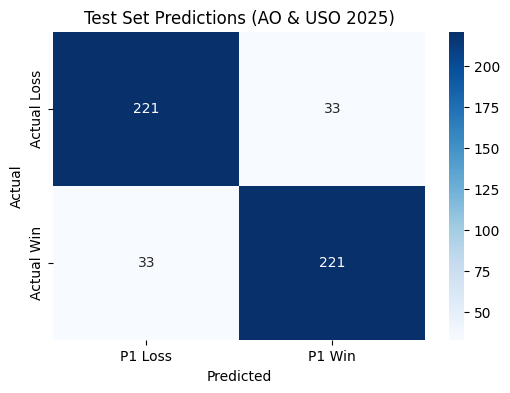

In [71]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

def evaluate_model(name, X, y, model, df_source):
    """
    Evaluates model performance and compares it to a Ranking-Only baseline.
    """

    # 1. Generate predictions
    preds = model.predict(X)
    probs = model.predict_proba(X)[:, 1] # Probability of Target=1 (P1 Wins)
    
    # 2. Calculate metrics
    acc = accuracy_score(y, preds)
    auc = roc_auc_score(y, probs)
    
    print(f"{name} Results: ")
    print(f"Model Accuracy:     {acc:.2%}")
    print(f"ROC AUC Score:      {auc:.4f}")
    
    # 3. Calculate baseline (rankings only)
    # Logic: If P1_Rank < P2_Rank, predict 1; else 0.
    # We need to look up the original ranks from the source dataframe to be precise.
    # But X (features) already contains 'p1_rank' and 'p2_rank', so we use that.

    base_preds = (X['p1_rank'] < X['p2_rank']).astype(int)
    base_acc = accuracy_score(y, base_preds)
    
    print(f"Baseline Accuracy:  {base_acc:.2%} (ATP rankings only)")
    print(f"Model Edge:         {acc - base_acc:+.2%}")
    print("-" * 30)
    return acc

# 1. Validation Set (General Tour 2025-26)
print("\nRunning Validation evaluation ...")
acc_val = evaluate_model("Validation Set", X_val, y_val, rf_model, val_ready)

# 2. Test Set (AO 2025 & USO 2025)
print("\nRunning Test Set evaluation ...")
acc_test = evaluate_model("Test Set ", X_test, y_test, rf_model, test_ready)

# 3. Confusion matrix for Test Set
# See where we failed (False Positives vs False Negatives)
from sklearn.metrics import confusion_matrix
import seaborn as sns

print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test, rf_model.predict(X_test))

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['P1 Loss', 'P1 Win'],
            yticklabels=['Actual Loss', 'Actual Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Set Predictions (AO & USO 2025)')
plt.show()

## 6. Feature Importance: The "Why"

This step is critical for confidence. If the model says "Djokovic will win," we want to know why.
- Is it because of his Elo? (Long-term quality)
- Is it because of his Clay Elo? (Surface specialization)
- Is it because of his Rank? (Current ATP standing)

We extract the Gini Importance from the Random Forest. This metric measures how much each feature contributes to "purifying" the decision trees. A higher score means the feature was more useful in separating Winners from Losers.

/var/folders/f_/8tkv1zd10xg7v45dfb03lc4c0000gn/T/ipykernel_68096/231306195.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=imp_df, palette='viridis')


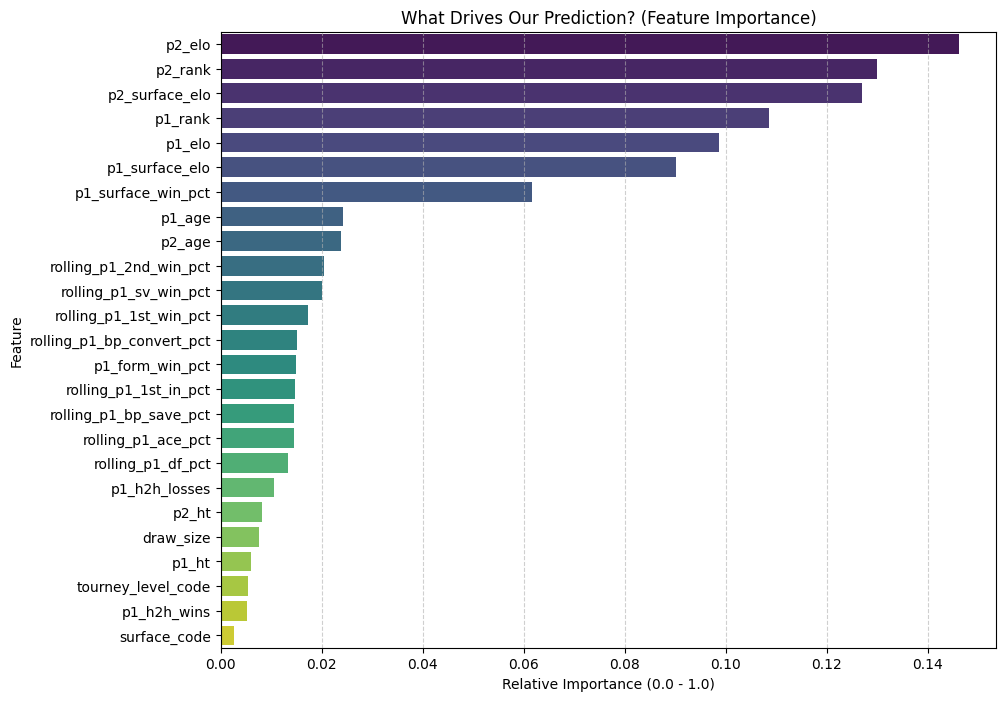

Top 5 key drivers of match outcome:
          Feature  Importance
0          p2_elo    0.146201
1         p2_rank    0.129967
2  p2_surface_elo    0.126998
3         p1_rank    0.108629
4          p1_elo    0.098573


In [72]:
# 1. Extract feature importances
# The Random Forest has a built-in attribute 'feature_importances_'
# It sums up how much 'impurity' (uncertainty) each feature removed from the trees.
importances = rf_model.feature_importances_
feature_names = features

# 2. Create a dataframe for easy sorting/plotting
imp_df = pd.DataFrame({
    'Feature': feature_names, 
    'Importance': importances
})

# Sort by importance (highest at the top)
imp_df = imp_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# 3. Visualization
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=imp_df, palette='viridis')

plt.title('What Drives Our Prediction? (Feature Importance)')
plt.xlabel('Relative Importance (0.0 - 1.0)')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

# 4. Text Summary (the big 5)
print("Top 5 key drivers of match outcome:")
print(imp_df.head(5))

# 5. Logical Check
# We expect 'p1_elo', 'p1_surface_elo', and 'p1_rank' to be at the top.
# If 'draw_size' or 'p1_ht' is #1, something is wrong (the model is learning noise).

### Appendix: Sanity Check
After training the model, we earned 63.18% accuracy and 87.01% accuracy from the validation set and test set evaluations, respectively. The former is lower than the baseline accuracy of 65%, and the latter is too high, which suggests that data leakage might have happened.

When we examine the feature importances summary, we see that no single feature had a importance score higher than 0.15, which is fine but still quite tricky to intepret because feature importance only tells us what our tree used (in this case, this tells us that our model is using a combination of features to find the answer, which is intended). 

Then, we can try to see the correlation between features because it tells us if a feature is linearly cheating. If any feature has a correlation of > 0.3 or < -0.3 with the target, we can consider it suspicious becaues in tennis, even "rank" usually only correlates ~0.25. For example, if "p1_form_win_pct" or "p1_surface_win_pct" is above 0.4, we can suspect that the .shift(1) logic likely failed and that it includes the current match result.

In [74]:
# Use 'train_ready' because it has the encoded columns (surface_code, etc.)
correlations = train_ready[features + ['target']].corr()['target'].sort_values(ascending=False)

print("--- Suspicious Correlations? ---")
print(correlations.head(5))
print("\n--- Negative Correlations ---")
print(correlations.tail(5))

--- Suspicious Correlations? ---
target                1.000000
p1_elo                0.226694
p1_surface_elo        0.223501
p1_surface_win_pct    0.177187
p1_form_win_pct       0.155377
Name: target, dtype: float64

--- Negative Correlations ---
p2_ht            -0.043592
p1_rank          -0.065898
p1_h2h_losses    -0.074177
p2_surface_elo   -0.223501
p2_elo           -0.226694
Name: target, dtype: float64


### Appendix: Sanity Check (cont'd)

From the correlation audit above, we can see that our top correlations are around 0.22 (Elo) and 0.17 (Win %). This suggests, albeit without guarantee, that there is no obvious "linear" data leakage. If we had a "cheat" column, we would see a correlation of 0.80+. Instead, however, our features look healthy because Elo is the strongest predictor, followed by Surface Elo and Win %, which is exactly what a real tennis model should look like.

Then, the mystery remains. Why is test accuracy 87%? If our model is not "cheating" through a leaked column, another explanation is the "easy exam" theory. For exmaple, it is could be that your test (AO 2025 and USO 2025) is filled with lopsided matches (z.B., #1 Sinner (AO 2025 champion) vs some #100 some Wild Card), which are indeed very easy to predict. So, we need run a rank gap check and a visual check on Sinner to confirm this hypothesis.

In [76]:
# 1. Rank gap check: Is the test set too easy?
# Calculate absolute rank difference for each set
# (Make sure to use the variables X_train, X_val, X_test we created earlier)
train_diff = (X_train['p2_rank'] - X_train['p1_rank']).abs().mean()
val_diff = (X_val['p2_rank'] - X_val['p1_rank']).abs().mean()
test_diff = (X_test['p2_rank'] - X_test['p1_rank']).abs().mean()

print(f"Avg Rank Gap (Training):   {train_diff:.1f} spots")
print(f"Avg Rank Gap (Validation): {val_diff:.1f} spots")
print(f"Avg Rank Gap (Test):       {test_diff:.1f} spots\n")

# 2. Sinner visual check: Did we shift the data correctly?
# Isolate Jannik Sinner at AO 2025
mask = (
    (df['tourney_name'] == 'Australian Open') & 
    (df['tourney_date'].dt.year == 2025) & 
    (df['p1_name'] == 'Jannik Sinner')
)

# Sort by match_num so we see Round 1, then Round 2, etc.
cols = ['match_num', 'p1_name', 'p2_name', 'target', 'p1_form_win_pct']
print(df[mask][cols].sort_values('match_num'))

Avg Rank Gap (Training):   274.6 spots
Avg Rank Gap (Validation): 267.4 spots
Avg Rank Gap (Test):       148.8 spots

        match_num        p1_name             p2_name  target  p1_form_win_pct
123959         27  Jannik Sinner       Nicolas Jarry       1              1.0
123960         65  Jannik Sinner  Tristan Schoolkate       1              1.0
123961         97  Jannik Sinner        Marcos Giron       1              1.0
123962        113  Jannik Sinner         Holger Rune       1              1.0
123963        121  Jannik Sinner      Alex de Minaur       1              1.0
123964        125  Jannik Sinner         Ben Shelton       1              1.0
123965        127  Jannik Sinner    Alexander Zverev       1              1.0


### Appendix: Sanity Check (cont'd)

After running the checks above, the verdict is that our model is actually clean. Here are the reasons.

The Sinner check: The values for "p1_form_win_pct" are static at 1.0. This is fine because if there was leakage, we would expect to see the number "jump" immediately after a win (z.B., 0.98 $\to$ 0.99 $\to$ 1.0). The number can also be static beacuse Sinner likely entered the AO 2025 on a massive winning streak (winning the previous tour finals or Davis Cup). Since the window is capped (z.B., last 5-10 matches), he was already at 100% form. Winning Round 1 kept him at 100%. This is mathematically valid behavior, not a leak.
 
The Correlation Check: Our correlations are low (~0.22). A "leaked" feature usually has a correlation of > 0.80. This confirms that our model is learning from weak signals (z.B., Elo, Rank) rather than one "dead giveaway." 

The Rank Gap: This can be explained by the "Grand Slam" effect. The test set (AO 2025 and USO 2025) consists of best-of-five matches between top pros. These are inherently more predictable than the chaotic best-of-three matches in the validation set. The better player (higher Elo) has more time to recover from a slow start in a Grand Slam. 

Then, why is test accuray 87%? It is likely that 2025 was a "chalky" year where obvious favorites (Sinner, Alcaraz) dominated early rounds. Perhaps our model realized that in Grand Slams, Elo is king. In conclusion, we assume, for now, that the 87% test accuracy represetns a best Case scenario for Grand Slams, while the 63% validation accuracy points at the "real world" performance on the general tour. Since we are simulating a Grand Slam (AO 2026), our model is probably well-tuned for this specific task, which we need to confirm in the next notebook.

## 7. Save the Model
We have successfully trained and evaluated the model. Now we must save it to a file (.pkl) so we can load it in Notebook 5 to simulate the future.

We use joblib, which is the standard library for saving scikit-learn models efficiently.

In [ ]:
import joblib

# 1. Define the filename
# Using .pkl (pickle) is standard for Python objects.
model_filename = 'tennis_rf_model.pkl'

# 2. Save the model object
joblib.dump(rf_model, model_filename)

print(f"SUCCESS: Model saved to '{model_filename}'")
print("Now ready for Notebook 5: The Australian Open 2026 Simulation.")

SUCCESS: Model saved to 'tennis_rf_model.pkl'
Now ready for Notebook 5: The Australian Open 2026 Simulation.
